In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
# import timm
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from PIL import Image

import pandas as pd
from torchvision.transforms import ToTensor
import torch.nn.functional as F

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import time
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
# from xgboost import XGBClassifier
from sklearn import svm

In [ ]:
# df = pd.read_csv('C:/Rupak/Icahn/Academics/Semester 5/MLBDS/Project/combined_matrix_AUD_scores_3categs.csv')
# df = pd.read_csv('/content/drive/MyDrive/Icahn/MLBDS/combined_matrix_100_AUD_scores.csv')
df = pd.read_csv('/content/drive/MyDrive/Icahn/MLBDS/raw_combined_matrix_AUD_scores.csv')

In [ ]:
df

,Unnamed: 0,index,URSI,AUD_total,filename
0,0,0,M06158716,9.0,sub-M06158716_100_combined.npy
1,1,1,M87100099,7.0,sub-M87100099_100_combined.npy
2,2,2,M87100246,11.0,sub-M87100246_100_combined.npy
3,3,3,M87100348,11.0,sub-M87100348_100_combined.npy
4,4,4,M87100391,11.0,sub-M87100391_100_combined.npy
...,...,...,...,...,...
376,393,466,M87199214,20.0,sub-M87199214_100_combined.npy
377,394,467,M87199357,8.0,sub-M87199357_100_combined.npy
378,395,468,M87199413,10.0,sub-M87199413_100_combined.npy
379,396,469,M87199665,26.0,sub-M87199665_100_combined.npy


In [ ]:
df[df['AUD_total'].isnull()]

,Unnamed: 0,index,URSI,AUD_total,filename


In [ ]:
#drop rows with missing AUD scores
indices_to_drop = np.where(df['AUD_total']==' ')[0]
df = df.drop(indices_to_drop)
df

,Unnamed: 0,index,URSI,AUD_total,filename
0,0,0,M06158716,9.0,sub-M06158716_100_combined.npy
1,1,1,M87100099,7.0,sub-M87100099_100_combined.npy
2,2,2,M87100246,11.0,sub-M87100246_100_combined.npy
3,3,3,M87100348,11.0,sub-M87100348_100_combined.npy
4,4,4,M87100391,11.0,sub-M87100391_100_combined.npy
...,...,...,...,...,...
376,393,466,M87199214,20.0,sub-M87199214_100_combined.npy
377,394,467,M87199357,8.0,sub-M87199357_100_combined.npy
378,395,468,M87199413,10.0,sub-M87199413_100_combined.npy
379,396,469,M87199665,26.0,sub-M87199665_100_combined.npy


count    381.000000
mean      13.994751
std        6.618552
min        3.000000
25%        9.000000
50%       13.000000
75%       18.000000
max       36.000000
Name: AUD_total, dtype: float64


<Axes: >

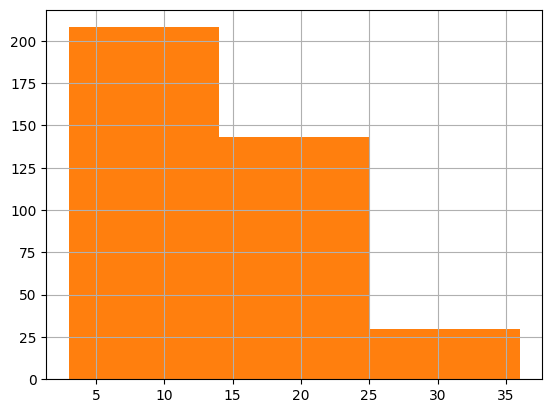

In [ ]:
#group AUD scores into 3 categories
df['AUD_total'] = df['AUD_total'].astype(float)
print(df['AUD_total'].describe())

df['AUD_total'].hist()

df['AUD_total'].hist(bins = 3)



In [ ]:
median = df['AUD_total'].median()
median

13.0

In [ ]:
#make a new column for AUD category based on 50th percentile
df['AUD_cat2_median'] = np.where(df['AUD_total'] > median, 1, 0).astype(float)
df['AUD_cat2_8'] = np.where(df['AUD_total'] > 8, 1, 0).astype(float)

In [ ]:
# df = df.rename(columns={"AUD_cat": "AUD_cat3"})
df

,Unnamed: 0,index,URSI,AUD_total,filename,AUD_cat2_median,AUD_cat2_8
0,0,0,M06158716,9.0,sub-M06158716_100_combined.npy,0.0,1.0
1,1,1,M87100099,7.0,sub-M87100099_100_combined.npy,0.0,0.0
2,2,2,M87100246,11.0,sub-M87100246_100_combined.npy,0.0,1.0
3,3,3,M87100348,11.0,sub-M87100348_100_combined.npy,0.0,1.0
4,4,4,M87100391,11.0,sub-M87100391_100_combined.npy,0.0,1.0
...,...,...,...,...,...,...,...
376,393,466,M87199214,20.0,sub-M87199214_100_combined.npy,1.0,1.0
377,394,467,M87199357,8.0,sub-M87199357_100_combined.npy,0.0,0.0
378,395,468,M87199413,10.0,sub-M87199413_100_combined.npy,0.0,1.0
379,396,469,M87199665,26.0,sub-M87199665_100_combined.npy,1.0,1.0


<Axes: >

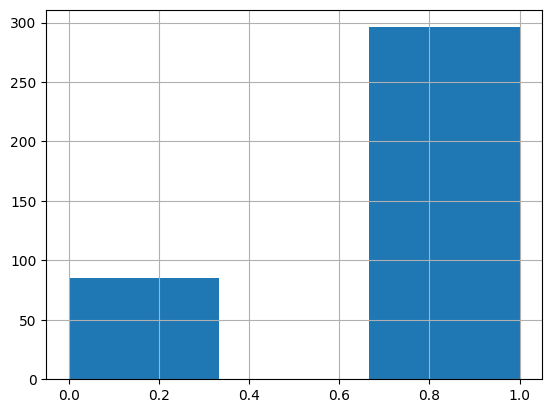

In [ ]:
df['AUD_cat2_8'].hist(bins = 3)

In [ ]:
# file_path = 'C:/Rupak/Icahn/Academics/Semester 5/MLBDS/Project/connectivity_matrix_combined/'
# file_path = '/content/drive/MyDrive/Icahn/MLBDS/connectivity_matrix_100_combined/'
file_path = '/content/drive/MyDrive/Icahn/MLBDS/raw_connectivity_matrix_combined/'
file_name = df['filename']
file_name

0      sub-M06158716_100_combined.npy
1      sub-M87100099_100_combined.npy
2      sub-M87100246_100_combined.npy
3      sub-M87100348_100_combined.npy
4      sub-M87100391_100_combined.npy
                    ...              
376    sub-M87199214_100_combined.npy
377    sub-M87199357_100_combined.npy
378    sub-M87199413_100_combined.npy
379    sub-M87199665_100_combined.npy
380    sub-M87199790_100_combined.npy
Name: filename, Length: 381, dtype: object

In [ ]:
# X_train3, X_test3, y_train3, y_test3 = train_test_split(df['filename'], df['AUD_cat3'], test_size=0.2, random_state=42)
X_train2_md, X_test2_md, y_train2_md, y_test2_md = train_test_split(df['filename'], df['AUD_cat2_median'], test_size=0.2, random_state=42)
X_train2_8, X_test2_8, y_train2_8, y_test2_8 = train_test_split(df['filename'], df['AUD_cat2_8'], test_size=0.2, random_state=42)


In [ ]:
def upper_triangle(matrix):
    upper = np.triu(matrix, k = 1)
    return upper

def flatten_upper(matrix):
    upper = upper_triangle(matrix)
    flattened = upper.flatten()
    return flattened

In [ ]:

# d_X_train3 = []
d_X_train2_md = []
d_X_train2_8 = []

# d_X_train3_f = []
d_X_train2_md_f = []
d_X_train2_8_f = []

# for i in X_train3:
#     d_X_train3.append(np.load(file_path + i))
# print(np.shape(d_X_train3))

for i in X_train2_md:
    d_X_train2_md.append(np.load(file_path + i))
print(np.shape(d_X_train2_md))

for i in X_train2_8:
    d_X_train2_8.append(np.load(file_path + i))
print(np.shape(d_X_train2_8))

# d_X_train3 = np.asarray(d_X_train3)
d_X_train2_md = np.asarray(d_X_train2_md)
d_X_train2_8 = np.asarray(d_X_train2_8)

# d_X_train3 = upper_triangle(d_X_train3)
# d_X_train2_md = upper_triangle(d_X_train2_md)
# d_X_train2_8 = upper_triangle(d_X_train2_8)

# nsamples, nx, ny = np.shape(d_X_train3)
nsamples, nx, ny = np.shape(d_X_train2_md)
nsamples, nx, ny = np.shape(d_X_train2_8)

# d_X_train3_f = np.reshape(d_X_train3, (nsamples, nx*ny))
d_X_train2_md_f = np.reshape(d_X_train2_md, (nsamples, nx*ny))
d_X_train2_8_f = np.reshape(d_X_train2_8, (nsamples, nx*ny))

# print(np.shape(d_X_train3_f))
print(np.shape(d_X_train2_md_f))
print(np.shape(d_X_train2_8_f))

# d_X_train3_f = np.asarray(d_X_train3_f)
d_X_train2_md_f = np.asarray(d_X_train2_md_f)
d_X_train2_8_f = np.asarray(d_X_train2_8_f)



## Test
# d_X_test3 = []
d_X_test2_md = []
d_X_test2_8 = []

# d_X_test3_f = []
d_X_test2_md_f = []
d_X_test2_8_f = []

# for i in X_test3:
#     d_X_test3.append(np.load(file_path + i))
# print(np.shape(d_X_test3))

for i in X_test2_md:
    d_X_test2_md.append(np.load(file_path + i))
print(np.shape(d_X_test2_md))

for i in X_test2_8:
    d_X_test2_8.append(np.load(file_path + i))
print(np.shape(d_X_test2_8))

# d_X_test3 = np.asarray(d_X_test3)
d_X_test2_md = np.asarray(d_X_test2_md)
d_X_test2_8 = np.asarray(d_X_test2_8)

# d_X_test3 = upper_triangle(d_X_test3)
# d_X_test2_md = upper_triangle(d_X_test2_md)
# d_X_test2_8 = upper_triangle(d_X_test2_8)

# nsamples, nx, ny = np.shape(d_X_test3)
nsamples, nx, ny = np.shape(d_X_test2_md)
nsamples, nx, ny = np.shape(d_X_test2_8)

# d_X_test3_f = np.reshape(d_X_test3, (nsamples, nx*ny))
d_X_test2_md_f = np.reshape(d_X_test2_md, (nsamples, nx*ny))
d_X_test2_8_f = np.reshape(d_X_test2_8, (nsamples, nx*ny))

# print(np.shape(d_X_test3_f))
print(np.shape(d_X_test2_md_f))
print(np.shape(d_X_test2_8_f))

# d_X_test3_f = np.asarray(d_X_test3_f)
d_X_test2_md_f = np.asarray(d_X_test2_md_f)
d_X_test2_8_f = np.asarray(d_X_test2_8_f)


(304, 100, 100)
(304, 100, 100)
(304, 10000)
(304, 10000)
(77, 100, 100)
(77, 100, 100)
(77, 10000)
(77, 10000)


In [ ]:
light_alcohol = d_X_train2_md[y_train2_md == 0]
print(np.shape(light_alcohol))
heavy_alcohol = d_X_train2_md[y_train2_md == 1]

(166, 100, 100)


In [ ]:
# light_alcohol = light_alcohol.squeeze(axis=1)
print(np.shape(light_alcohol))
# heavy_alcohol = heavy_alcohol.squeeze(axis=1)
print(np.shape(heavy_alcohol))

(166, 100, 100)
(138, 100, 100)


In [ ]:
mean_light_alcohol = np.mean(light_alcohol, axis=0)
mean_heavy_alcohol = np.mean(heavy_alcohol, axis=0)

<Axes: >

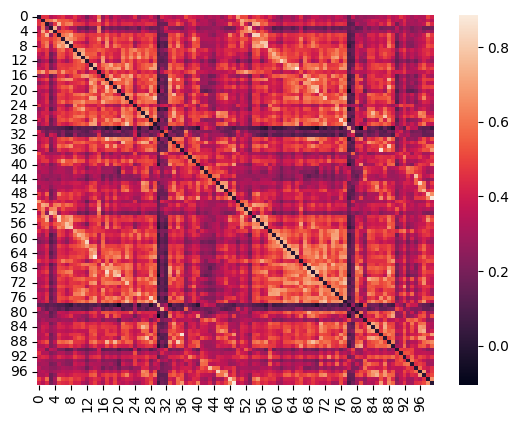

In [ ]:
import seaborn as sns
sns.heatmap(mean_light_alcohol)

<Axes: >

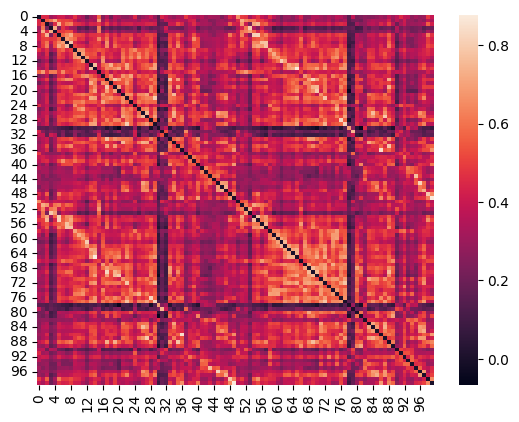

In [ ]:
sns.heatmap(mean_heavy_alcohol)

In [ ]:
from sklearn import svm
# clf3 = svm.SVC(class_weight='balanced')
clf2_md = svm.SVC(class_weight='balanced')
clf2_8 = svm.SVC(class_weight='balanced')

# clf3.fit(d_X_train3_f, y_train3)
clf2_md.fit(d_X_train2_md_f, y_train2_md)
clf2_8.fit(d_X_train2_8_f, y_train2_8)

SVC(class_weight='balanced')

In [ ]:
# y_pred3 = clf3.predict(d_X_test3_f)
y_pred2_md = clf2_md.predict(d_X_test2_md_f)
y_pred2_8 = clf2_8.predict(d_X_test2_8_f)

In [ ]:
# print(sum(y_pred3 == y_test3))
print(sum(y_pred2_md == y_test2_md))
print(sum(y_pred2_8 == y_test2_8))

42
51


In [ ]:
# print(classification_report(y_test3, y_pred3))
print(classification_report(y_test2_md, y_pred2_md))
print(classification_report(y_test2_8, y_pred2_8))

              precision    recall  f1-score   support

         0.0       0.58      0.60      0.59        42
         1.0       0.50      0.49      0.49        35

    accuracy                           0.55        77
   macro avg       0.54      0.54      0.54        77
weighted avg       0.54      0.55      0.54        77

              precision    recall  f1-score   support

         0.0       0.28      0.28      0.28        18
         1.0       0.78      0.78      0.78        59

    accuracy                           0.66        77
   macro avg       0.53      0.53      0.53        77
weighted avg       0.66      0.66      0.66        77



In [ ]:
from tqdm import tqdm
class ClassifierGridSearch(object):

    def __init__(self, classifier_dict, params_dict):
        """
        Accepts a dictionary of classifiers and parameter grids and performs a cross validated grid search
        """
        self.classifier_dict = classifier_dict
        self.params_dict = params_dict

    def grid_search(self, X, y, **grid_kwargs):
        """
            search hyperparameter space
                kwargs: sklearn args - scoring metric, cv, n_folds, etc
                ?specify what kind of scoring exists?
        """
        self.X = X
        self.y = y
        self.grid_searches = {} # to output

        for c, (self.name, classifier) in enumerate(self.classifier_dict.items()):
            start_time = time.time()
            print('Running GridSearchCV for %s.' % self.name)
            search_params = self.params_dict[self.name] # get the parameters grid
            grid_search = GridSearchCV(classifier, search_params, **grid_kwargs) # create object
            grid_search.fit(self.X, self.y) # fit
            self.grid_searches[self.name] = grid_search # create a grid search dict
            print("Time to run %s: %s seconds " % (self.name, (time.time() - start_time)), '\n')
        print('Done.')

    def grid_test(self, X, y):
        self.X = X
        self.y = y
        self.grid_test = {}

        for c, (self.name, classifier) in enumerate(self.classifier_dict.items()):
            print('Running test for %s.' % self.name)
            model = self.grid_searches[self.name]
            y_pred = model.predict(X)
            test_result = model.score(X, y)
            self.grid_test[self.name] = test_result
            print('{} Test Accuracy: {}'.format(self.name, test_result))
            print('{} Confusion matrix: {}'.format(self.name, classification_report(y, y_pred)))
            print('{} Best Params: {}'.format(self.name, model.best_params_))

In [ ]:
max_iter = 100000
random_state = 1
clf_grid    = {
                'SVM1': svm.SVC(random_state=42),
               'SVM2': svm.SVC(random_state=42),
                # 'SGDClassifier': SGDClassifier(random_state=random_state, max_iter=max_iter)
#               'LogisticRegression': LogisticRegression(random_state=42, max_iter=max_iter),
              'DecisionTree': DecisionTreeClassifier(random_state=42),
#               'RandomForestClassifier': RandomForestClassifier(random_state=42),
              'KNeighbours': KNeighborsClassifier()

#               'XGB': XGBClassifier(random_state=42)
}

# clf_grid = {'LogisticRegression': LogisticRegression(random_state=42)}

param_range = [1, 2, 3, 4, 5, 6]
param_range_fl = [1.0, 0.5, 0.1]
n_estimators = [50,100,150]
learning_rates = [.1,.2,.3]

# param_grid = {'SGDClassifier': {
#         'loss': ['log'],
#         'penalty': ['l2'],
#         'l1_ratio': np.linspace(0.1,1,10),
#         'alpha': [0.1]}}

# param_grid = {
#     'LogisticRegression': {
#         'penalty': ['l2', None],
#         'C': param_range_fl,
#         'class_weight': [None, 'balanced'],
#         'solver': ['newton-cg', 'sag', 'saga']}
# }


param_grid = {
    'SVM1': {
            'kernel': ['rbf'],
            'C': [1, 10, 100, 1000],
            'gamma': [1e-1, 1e-2, 1e-3, 1e-4],
            'class_weight': ['balanced']
         },
    'SVM2': {
            'kernel': ['linear'],
            'C': [1, 10, 100, 1000],
            'class_weight': ['balanced']
         },

    # 'SGDClassifier': {
    #     'loss': ['log', 'hinge'],
    #     'penalty': ['l1', 'l2', 'elasticnet'],
    #     'l1_ratio': np.linspace(0.1,1,10),
    #     'alpha': [0.0001, 0.1, 1, 5, 25, 100]}
#     'LogisticRegression': {
#         'penalty': ['l2'],
#         'C': param_range_fl,
#         'class_weight': [None, 'balanced'],
#         'solver': ['newton-cg', 'sag', 'saga']},
    'DecisionTree': {
        'criterion': ['gini', 'entropy'],
        'min_samples_leaf': param_range,
        'max_depth': param_range[:3],
        'min_samples_split': param_range[1:]},
#     'RandomForestClassifier': {
#         'criterion': ['gini', 'entropy'],
#         'min_samples_leaf': param_range,
#         'max_depth': param_range,
#         'min_samples_split': param_range[1:]},
    'KNeighbours': {
        'n_neighbors': param_range,
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']}

#     'XGB': {
#         'learning_rate': learning_rates,
#         'max_depth': param_range,
#         'min_child_weight': param_range[:2],
#         'subsample': param_range_fl}
}


In [ ]:
# cl3 = ClassifierGridSearch(clf_grid, param_grid)
# cl3.grid_search(d_X_train3_f, y_train3, cv=10, verbose=3)

In [ ]:
# cl3.grid_test(d_X_test3_f, y_test3)

In [ ]:
cl2_8 = ClassifierGridSearch(clf_grid, param_grid)
cl2_8.grid_search(d_X_train2_8_f, y_train2_8, cv=10, verbose=3)


Running GridSearchCV for SVM1.
Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV 1/10] END C=1, class_weight=balanced, gamma=0.1, kernel=rbf;, score=0.774 total time=   0.4s
[CV 2/10] END C=1, class_weight=balanced, gamma=0.1, kernel=rbf;, score=0.774 total time=   0.4s
[CV 3/10] END C=1, class_weight=balanced, gamma=0.1, kernel=rbf;, score=0.774 total time=   0.4s
[CV 4/10] END C=1, class_weight=balanced, gamma=0.1, kernel=rbf;, score=0.774 total time=   0.4s
[CV 5/10] END C=1, class_weight=balanced, gamma=0.1, kernel=rbf;, score=0.800 total time=   0.4s
[CV 6/10] END C=1, class_weight=balanced, gamma=0.1, kernel=rbf;, score=0.800 total time=   0.4s
[CV 7/10] END C=1, class_weight=balanced, gamma=0.1, kernel=rbf;, score=0.800 total time=   0.4s
[CV 8/10] END C=1, class_weight=balanced, gamma=0.1, kernel=rbf;, score=0.767 total time=   0.4s
[CV 9/10] END C=1, class_weight=balanced, gamma=0.1, kernel=rbf;, score=0.767 total time=   0.3s
[CV 10/10] END C=1, class_weight=

In [ ]:
cl2_8.grid_test(d_X_test2_8_f, y_test2_8)

Running test for SVM1.
SVM1 Test Accuracy: 0.7662337662337663
SVM1 Confusion matrix:               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        18
         1.0       0.77      1.00      0.87        59

    accuracy                           0.77        77
   macro avg       0.38      0.50      0.43        77
weighted avg       0.59      0.77      0.66        77

SVM1 Best Params: {'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}
Running test for SVM2.
SVM2 Test Accuracy: 0.6883116883116883
SVM2 Confusion matrix:               precision    recall  f1-score   support

         0.0       0.20      0.11      0.14        18
         1.0       0.76      0.86      0.81        59

    accuracy                           0.69        77
   macro avg       0.48      0.49      0.48        77
weighted avg       0.63      0.69      0.65        77

SVM2 Best Params: {'C': 1, 'class_weight': 'balanced', 'kernel': 'linear'}
Running test fo

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KNeighbours Test Accuracy: 0.7792207792207793
KNeighbours Confusion matrix:               precision    recall  f1-score   support

         0.0       1.00      0.06      0.11        18
         1.0       0.78      1.00      0.87        59

    accuracy                           0.78        77
   macro avg       0.89      0.53      0.49        77
weighted avg       0.83      0.78      0.69        77

KNeighbours Best Params: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}


## Only the upper triangle

In [ ]:

# d_X_train3 = []
d_X_train2_md = []
d_X_train2_8 = []

# d_X_train3_f = []
d_X_train2_md_f = []
d_X_train2_8_f = []

# for i in X_train3:
#     d_X_train3.append(np.load(file_path + i))
# print(np.shape(d_X_train3))

for i in X_train2_md:
    d_X_train2_md.append(np.load(file_path + i))
print(np.shape(d_X_train2_md))

for i in X_train2_8:
    d_X_train2_8.append(np.load(file_path + i))
print(np.shape(d_X_train2_8))

# d_X_train3 = np.asarray(d_X_train3)
d_X_train2_md = np.asarray(d_X_train2_md)
d_X_train2_8 = np.asarray(d_X_train2_8)

# d_X_train3 = upper_triangle(d_X_train3)
d_X_train2_md = upper_triangle(d_X_train2_md)
d_X_train2_8 = upper_triangle(d_X_train2_8)

# nsamples, nx, ny = np.shape(d_X_train3)
nsamples, nx, ny = np.shape(d_X_train2_md)
nsamples, nx, ny = np.shape(d_X_train2_8)

# d_X_train3_f = np.reshape(d_X_train3, (nsamples, nx*ny))
d_X_train2_md_f = np.reshape(d_X_train2_md, (nsamples, nx*ny))
d_X_train2_8_f = np.reshape(d_X_train2_8, (nsamples, nx*ny))

# print(np.shape(d_X_train3_f))
print(np.shape(d_X_train2_md_f))
print(np.shape(d_X_train2_8_f))

# d_X_train3_f = np.asarray(d_X_train3_f)
d_X_train2_md_f = np.asarray(d_X_train2_md_f)
d_X_train2_8_f = np.asarray(d_X_train2_8_f)



## Test
# d_X_test3 = []
d_X_test2_md = []
d_X_test2_8 = []

# d_X_test3_f = []
d_X_test2_md_f = []
d_X_test2_8_f = []

# for i in X_test3:
#     d_X_test3.append(np.load(file_path + i))
# print(np.shape(d_X_test3))

for i in X_test2_md:
    d_X_test2_md.append(np.load(file_path + i))
print(np.shape(d_X_test2_md))

for i in X_test2_8:
    d_X_test2_8.append(np.load(file_path + i))
print(np.shape(d_X_test2_8))

# d_X_test3 = np.asarray(d_X_test3)
d_X_test2_md = np.asarray(d_X_test2_md)
d_X_test2_8 = np.asarray(d_X_test2_8)

# d_X_test3 = upper_triangle(d_X_test3)
d_X_test2_md = upper_triangle(d_X_test2_md)
d_X_test2_8 = upper_triangle(d_X_test2_8)

# nsamples, nx, ny = np.shape(d_X_test3)
nsamples, nx, ny = np.shape(d_X_test2_md)
nsamples, nx, ny = np.shape(d_X_test2_8)

# d_X_test3_f = np.reshape(d_X_test3, (nsamples, nx*ny))
d_X_test2_md_f = np.reshape(d_X_test2_md, (nsamples, nx*ny))
d_X_test2_8_f = np.reshape(d_X_test2_8, (nsamples, nx*ny))

# print(np.shape(d_X_test3_f))
print(np.shape(d_X_test2_md_f))
print(np.shape(d_X_test2_8_f))

# d_X_test3_f = np.asarray(d_X_test3_f)
d_X_test2_md_f = np.asarray(d_X_test2_md_f)
d_X_test2_8_f = np.asarray(d_X_test2_8_f)


(304, 100, 100)
(304, 100, 100)


NameError: ignored

In [ ]:
# clf3 = svm.SVC(class_weight='balanced')
clf2_md = svm.SVC(class_weight='balanced')
clf2_8 = svm.SVC(class_weight='balanced')

# clf3.fit(d_X_train3_f, y_train3)
clf2_md.fit(d_X_train2_md_f, y_train2_md)
clf2_8.fit(d_X_train2_8_f, y_train2_8)



In [ ]:
# y_pred3 = clf3.predict(d_X_test3_f)
y_pred2_md = clf2_md.predict(d_X_test2_md_f)
y_pred2_8 = clf2_8.predict(d_X_test2_8_f)

In [ ]:
# print(sum(y_pred3 == y_test3))
print(sum(y_pred2_md == y_test2_md))
print(sum(y_pred2_8 == y_test2_8))

In [ ]:
# print(classification_report(y_test3, y_pred3))
print(classification_report(y_test2_md, y_pred2_md))
print(classification_report(y_test2_8, y_pred2_8))

In [ ]:
cl2_8_u = ClassifierGridSearch(clf_grid, param_grid)
cl2_8_u.grid_search(d_X_train2_8_f, y_train2_8, cv=10, verbose=3)


Running GridSearchCV for SVM1.
Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV 1/10] END C=1, class_weight=balanced, gamma=0.1, kernel=rbf;, score=0.774 total time=   0.4s
[CV 2/10] END C=1, class_weight=balanced, gamma=0.1, kernel=rbf;, score=0.774 total time=   0.4s
[CV 3/10] END C=1, class_weight=balanced, gamma=0.1, kernel=rbf;, score=0.774 total time=   0.4s
[CV 4/10] END C=1, class_weight=balanced, gamma=0.1, kernel=rbf;, score=0.774 total time=   0.4s
[CV 5/10] END C=1, class_weight=balanced, gamma=0.1, kernel=rbf;, score=0.800 total time=   0.4s
[CV 6/10] END C=1, class_weight=balanced, gamma=0.1, kernel=rbf;, score=0.800 total time=   0.4s
[CV 7/10] END C=1, class_weight=balanced, gamma=0.1, kernel=rbf;, score=0.800 total time=   0.4s
[CV 8/10] END C=1, class_weight=balanced, gamma=0.1, kernel=rbf;, score=0.767 total time=   0.4s
[CV 9/10] END C=1, class_weight=balanced, gamma=0.1, kernel=rbf;, score=0.767 total time=   0.4s
[CV 10/10] END C=1, class_weight=

In [ ]:
cl2_8_u.grid_test(d_X_test2_8_f, y_test2_8)

Running test for SVM1.
SVM1 Test Accuracy: 0.7662337662337663
SVM1 Confusion matrix:               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        18
         1.0       0.77      1.00      0.87        59

    accuracy                           0.77        77
   macro avg       0.38      0.50      0.43        77
weighted avg       0.59      0.77      0.66        77

SVM1 Best Params: {'C': 10, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf'}
Running test for SVM2.
SVM2 Test Accuracy: 0.6883116883116883
SVM2 Confusion matrix:               precision    recall  f1-score   support

         0.0       0.20      0.11      0.14        18
         1.0       0.76      0.86      0.81        59

    accuracy                           0.69        77
   macro avg       0.48      0.49      0.48        77
weighted avg       0.63      0.69      0.65        77

SVM2 Best Params: {'C': 1, 'class_weight': 'balanced', 'kernel': 'linear'}
Running test 

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


KNeighbours Test Accuracy: 0.7792207792207793
KNeighbours Confusion matrix:               precision    recall  f1-score   support

         0.0       1.00      0.06      0.11        18
         1.0       0.78      1.00      0.87        59

    accuracy                           0.78        77
   macro avg       0.89      0.53      0.49        77
weighted avg       0.83      0.78      0.69        77

KNeighbours Best Params: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}


In [ ]:
# sgd_results2_md = pd.DataFrame(cl2_md.grid_searches['SGDClassifier'].cv_results_)

In [ ]:
# sgd_results8
# sgd_results_sorted8 = sgd_results8.sort_values("rank_test_score")
# print(sgd_results_sorted8.iloc[0])
# sgd_results_sorted8.iloc[0]['params']

In [ ]:
d_X_train2_8 = np.expand_dims(d_X_train2_8, axis=1)
d_X_test2_8 = np.expand_dims(d_X_test2_8, axis=1)

print(np.shape(d_X_train2_8))
print(np.shape(d_X_test2_8))

(304, 1, 100, 100)
(77, 1, 100, 100)


In [ ]:
from torch import Tensor

d_X_train2_8 = torch.Tensor(d_X_train2_8)
d_X_test2_8 = torch.Tensor(d_X_test2_8)
y_train2_8 = torch.Tensor(y_train2_8.to_numpy())
y_test2_8 = torch.Tensor(y_test2_8.to_numpy())

In [ ]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(d_X_train2_8, y_train2_8)
test_dataset = TensorDataset(d_X_test2_8, y_test2_8)

In [ ]:
#make a custom dataloader
# train_dataset = CustomDataset(X_train, y_train, transform = ToTensor())
# test_dataset = CustomDataset(X_test, y_test, transform = ToTensor())

train_loader = DataLoader(train_dataset, batch_size = 34, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 34, shuffle = True)


In [ ]:
def model_eval(model, loader_, criterion):
    # Test the model
    model.eval()
    eval_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in loader_:
            output = model(images)
            eval_loss += criterion(output, labels).item()
            #pred = output.argmax(dim=1, keepdim=True)
            # pred = (pred>0.5)
            pred = output>0.5
            pred = pred.type('torch.FloatTensor')
            correct += pred.eq(labels.view_as(pred)).sum().item()

    eval_loss /= len(loader_)
    eval_acc = correct/len(loader_.dataset)
    return eval_loss, eval_acc

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(100,1), stride=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            # nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=(1,100), stride=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False)
            # nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            #nn.Linear(16 * 5 * 5, 120),
            nn.Linear(128, 96),
            nn.ReLU(inplace=True),
            nn.Linear(96, 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, num_classes),
            nn.Sigmoid()
#             nn.Linear(84, 10),
#             nn.ReLU(inplace=True),
#             nn.Linear(10, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# model = LeNet5(num_classes=1)  # Set num_classes=1 for regression tasks


In [ ]:
model = LeNet5(num_classes=1)
# model = model.to(device)
#explaination of the model
#input size is 264, which is the number of nodes in the brain
#output size is 1, which is the AUD score

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

#train the model
num_epochs = 1000
total_step = len(train_loader)
train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_acc = 0

for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0
    correct = 0
    for i, (images, labels) in enumerate(train_loader):
#         images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        #print(images.shape)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        pred = outputs>0.5
        pred = pred.type('torch.FloatTensor')
        #pred = outputs.argmax(dim=1, keepdim=True)
        correct += pred.eq(labels.view_as(pred)).sum().item()

        train_loss /= len(train_loader)
        train_acc = correct / len(train_dataset)
        val_loss, val_acc = model_eval(model, test_loader, criterion)
        # print(i)
        if (i+1) % 3 == 0 and (epoch+1) % 50==0 :
            print("\n")
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)





NameError: ignored

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(train_accs, label='train accs')
plt.plot(val_accs, label='val accs')
plt.legend()
plt.show()